In [ ]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind

import ipywidgets as widgets

from tqdm.notebook import tqdm

In [ ]:
titlesize = 16
labelsize = 16
legendsize = 16
xticksize = 16
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Размер выборки

Посмотрим как ошибки первого и второго рода зивисят от величины эффекта и дисперсии.

$\beta = 1 - \Phi(\frac{\varepsilon}{\sigma} - \Phi^{-1}(1 - \alpha))$

In [ ]:
x = np.linspace(-4, 6, 1001)
H0_dist = stats.norm()
H0_pdf = H0_dist.pdf(x)

def get_beta(alpha, H1_mean, H1_std=1.0, two_side=False):
    H0_dist = stats.norm()
    if two_side:
        alpha = alpha / 2

    right_bound = H0_dist.ppf(1 - alpha)
    H1_dist = stats.norm(loc=H1_mean, scale=H1_std)
    beta = H1_dist.cdf(right_bound)
    if two_side:
        beta -= H1_dist.cdf(-right_bound)
    return beta
    
def plot_first_second_type_errors(H1_mean, H1_std, alpha, two_side=True):
    H1_dist = stats.norm(loc=H1_mean, scale=H1_std)
    H1_pdf = H1_dist.pdf(x)
    plt.figure(figsize=(10, 5))
    plt.plot(x, H0_pdf, label='H0 distribution')
    plt.plot(x, H1_pdf, label='H1 distribution')

    beta = get_beta(alpha, H1_mean, H1_std, two_side=two_side)
    cr_bound = alpha / 2 if two_side else alpha
    x_left, x_right = H0_dist.ppf(cr_bound), H0_dist.ppf(1 - cr_bound)
    alpha_error_left = np.linspace(-4, x_left, 101)
    alpha_error_right = np.linspace(x_right, 6, 101)
    # beta_error = np.linspace(x_left, x_right, 101)
    if two_side:
        plt.fill_between(alpha_error_left, H1_dist.pdf(alpha_error_left), color='green', alpha=0.25)
        plt.fill_between(alpha_error_left, H0_dist.pdf(alpha_error_left), color='red', alpha=0.25)
    plt.fill_between(alpha_error_right, H1_dist.pdf(alpha_error_right), color='green', alpha=0.25)
    plt.fill_between(alpha_error_right, H0_dist.pdf(alpha_error_right), color='red', alpha=0.25)
    # plt.fill_between(beta_error, H1_dist.pdf(beta_error), color='yellow', alpha=0.25)

    title = f'Критические области {"двустороннего" if two_side else "одностороннего"} критерия'
    plt.title(title, size=16)
    plt.legend(loc=2, fontsize=14)
    annotation = f'alpha = {alpha:.3f}\npower = {1-beta:.3f}'
    plt.text(-4.1, 0.26, annotation, size=18)
    plt.grid()
    plt.savefig(f'{"two" if two_side else "one"}_side_critical.png')
    plt.show()

interactive_plot = widgets.interactive(
    plot_first_second_type_errors, 
    H1_mean=widgets.FloatSlider(value=2,min=0,max=6,step=0.1,description='H1 mean:'),
    H1_std=widgets.FloatSlider(value=2,min=0.5,max=2,step=0.1,description='H1 std:'),
    alpha=widgets.FloatSlider(value=0.1,min=0.01,max=0.25,step=0.01,description='alpha:'),
    two_side=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='H1 mean:', max=6.0), FloatSlider(value=2.0, descript…

In [ ]:
plt.rcParams['axes.titlesize'] = 24

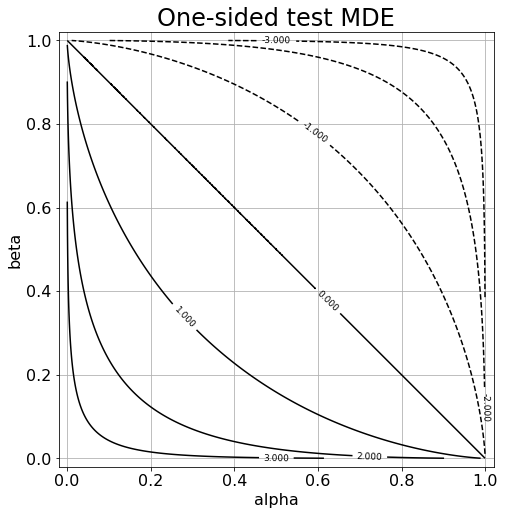

In [ ]:
delta = 0.0005
dist = stats.norm(loc=0, scale=1)

x = np.arange(0.0, 1.0, delta)
y = np.arange(0.0, 1.0, delta)
X, Y = np.meshgrid(x, y)
MDE = dist.ppf(1 - X) + dist.ppf(1 - Y)

fig, ax = plt.subplots(figsize=(8,8))
CS = ax.contour(X, Y, MDE, levels=np.arange(-3, 4), colors='k')  # Negative contours default to dashed.
ax.clabel(CS, fontsize=9, inline=True)
ax.set_title('One-sided test MDE')
ax.set_aspect('equal')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.grid()
fig.savefig('one_sided_mde.png')

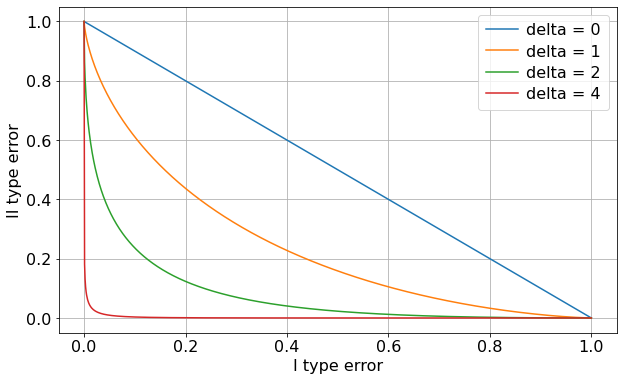

In [ ]:
alpha = np.linspace(0, 1, 1001)

for h1_mean in [0, 1, 2, 4]:
    plt.plot(alpha, get_beta(alpha=alpha, H1_mean=h1_mean, two_side=False),
             label=f'delta = {h1_mean}')

plt.xlabel('I type error')
plt.ylabel('II type error')
plt.legend()

plt.grid()

Напишем функцию для оценки размера выборки. Проверим на искусственных данных, что она работает корректно.

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Реализуем эту формулу для случая равных дисперсий:

In [ ]:
# нужно добавить варианты для односторонней и двусторонней гипотез...

def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

Часто нам интересно не абсолютное, а относительное изменение, эффект может быть посчитан как относительное увеличение среднего значения. Пересчитаем минимальный размер в этих терминах:

In [ ]:
def get_sample_size_arb(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    epsilon = (eff - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

In [ ]:
mu = 10
std = 1
eff = 1.01
alpha = 0.05
beta = 0.2


sample_size = get_sample_size_arb(mu, std, eff, alpha, beta)
print(f'sample_size = {sample_size}\n')


print('Ошибки I и II рода:')
for _ in range(10):
    result_aa = []
    result_ab = []
    for _ in range(10000):
        a_one = np.random.normal(mu, std, sample_size)
        a_two = np.random.normal(mu, std, sample_size)
        b = np.random.normal(mu * eff, std, sample_size)
        result_aa.append(check_ttest(a_one, a_two))
        result_ab.append(check_ttest(a_one, b))
    error_first = np.mean(result_aa)
    error_second = 1 - np.mean(result_ab)
    print(f'  {error_first:0.3f} \t{error_second:0.3f}')

sample_size = 1570

Ошибки I и II рода:
  0.047 	0.195
  0.048 	0.191
  0.048 	0.193
  0.050 	0.201
  0.052 	0.198
  0.050 	0.197
  0.051 	0.199
  0.047 	0.197
  0.051 	0.200
  0.055 	0.199


Видно, что получаем ошибки, которые и закладывали. Функция работает корректно.

## Цена ошибки
mu и std мы можем оценить по историческим данным, alpha и beta - определяем сами допустимые для нас ошибки. Как определить ожидаемый эффект, к чему могут привести завышенные ожидания?

Смоделируем ситуации, когда ожидаемый и реальный эффект не совпадаю, посмотрим как будет меняться ошибка второго рода.

sample_size = 252



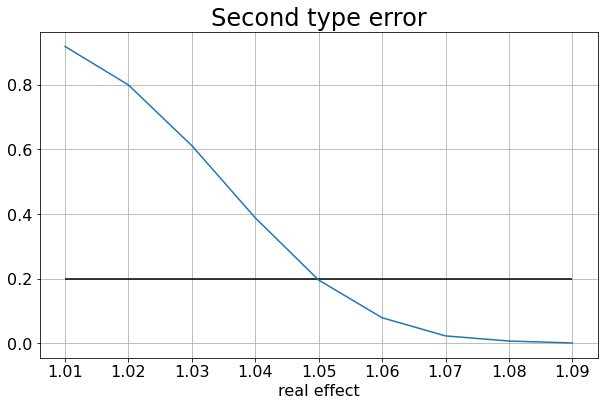

In [ ]:
mu = 10
std = 2
eff = 1.05
alpha = 0.05
beta = 0.2

real_effs = np.linspace(1.01, 1.09, 9)


sample_size = get_sample_size_arb(mu, std, eff, alpha, beta)
print(f'sample_size = {sample_size}\n')

second_errors = []
for real_eff in real_effs:
    result_ab = []
    for _ in range(10000):
        a = np.random.normal(mu, std, sample_size)
        b = np.random.normal(mu * real_eff, std, sample_size)
        result_ab.append(check_ttest(a, b))
    second_errors.append(1 - np.mean(result_ab))



plt.plot(real_effs, second_errors)
plt.title('Second type error')
plt.hlines(0.2, 1.01, 1.09, label='beta')
plt.xlabel('real effect')
plt.grid()
plt.show()

Получаем, что если мы ошиблись в эффекте на 1%, думали будет 5%, а оказалось 4%, то это увеличивает ошибку второго рода в два раза, с 20% до 40%.

Если есть возможность, лучше собирать данных с запасом.

## Различные сценарии
Давайте посмотрим, сколько нужно данных, чтобы отлавливать различные эффекты с различными ошибками первого и второго рода.

In [ ]:
def get_table_sample_size(mu, std, effects, errors):
    results = []
    for eff in effects:
        results_eff = []
        for err in errors:
            results_eff.append(
                get_sample_size_arb(
                    mu,
                    std,
                    eff=eff,
                    alpha=err,
                    beta=err
                )
            )
        results.append(results_eff)
        
    df_results = pd.DataFrame(results)
    df_results.index = pd.MultiIndex(
        levels=[[f'{np.round((x - 1)*100, 1)}%' for x in effects]],
        codes=[np.arange(len(effects))],
        names=['effects']
    )
    df_results.columns = pd.MultiIndex.from_tuples(
        [(err, ) for err in errors],
        names=['errors']
    )
    return df_results

In [ ]:
effects = np.linspace(1.01, 1.1, 10)
errors = [0.05, 0.1, 0.15, 0.2]

get_table_sample_size(10, 2, effects, errors)

errors,0.05,0.10,0.15,0.20
effects,,,,
1.0%,10396,6852,4905,3607
2.0%,2599,1713,1227,902
3.0%,1156,762,545,401
4.0%,650,429,307,226
5.0%,416,275,197,145
6.0%,289,191,137,101
7.0%,213,140,101,74
8.0%,163,108,77,57
9.0%,129,85,61,45


# 2. MDE
У нас есть данные с датчика, измеряющего температуру холодильника. Был проведён эксперимент по замене изоляционной прокладки на новую, это должно повысить теплоизоляцию, и холодильник, работая на той же мощности будет держать более низкую температру. Соответственно это позволит держать прежнюю температуру, тратя меньше энергии.

Обещают что с новой прокладкой температру будет ниже на 1 градус. Для эксперимента было выделено два холодильника, в одном заменил прокладку, в другом оставили как было. В течение трёх пользовались холодильниками одинаково. Нужно оценить есть эффект или нет.

Данные измеряются раз в 10 минуту.

Загрузим данные и оценим значимость отличия средней температуры тестом Стьюдента.

In [ ]:
URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'

def read_database(file_name):
    return pd.read_csv(URL_BASE + file_name)

data = read_database('sem22_mde.csv')

print(data.shape)
data.head()

(432, 2)


,a,b
0,3.309855,3.215963
1,3.941470,3.633339
2,3.625108,3.530082
3,3.669770,3.380595
4,3.576930,3.247619


In [ ]:
a = data['a'].values
b = data['b'].values

ttest_ind(a, b)

Ttest_indResult(statistic=1.8918383531968272, pvalue=0.058847466914040164)

In [ ]:
print(f'a.mean = {a.mean()}')
print(f'b.mean = {b.mean()}')
print(f'delta = {b.mean() - a.mean()}')

a.mean = 3.3365103599182677
b.mean = 3.1599520235296996
delta = -0.1765583363885681


Мы видим различие в средних значениях. Оно составляет -0.17 градуса. Это отличие для наших данных не статистически значимое. Давайте проверим, какой эффект могли поймать на таких данных на таком объеме данных.

$$\varepsilon^2 > \frac{\left[ \Phi^{-1} \left( 1-\dfrac{\alpha}{2} \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{n}$$

Оценим MDE по данными из группы A.

In [ ]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

In [ ]:
mu = a.mean()
std = a.std()
sample_size = len(a)
alpha = 0.05
beta = 0.2

mde = get_minimal_determinable_effect(std, sample_size, alpha, beta)

print(f'MDE = {mde}')

MDE = 0.26347043861700814


На таких данных можно поймать эффект на 0.26 градуса, мы ожидали эффект на 1 градус. Эффекта в 1 градус тут наверняка нет, тк мы его с большой вероятностью нашли бы.

Но вдруг для бизнес решения хватит и указанного различия в 0.17 градуса? Давайте проанализизуем наш тест, попробуем понять всё ли мы сделали правильно. И нет ли возможности увеличить чувствительность.

## Variance reduction

Получили, что отличия между группами не являются статистически значимыми. А можно ли как-то сделать тест более чувствительным, чтобы находить более меликие отличия? Посмотри на формулу для оценки MDE. Для увеличения чувствительности нужно снижать дисперсию!



Давайте посмотрим на данные.

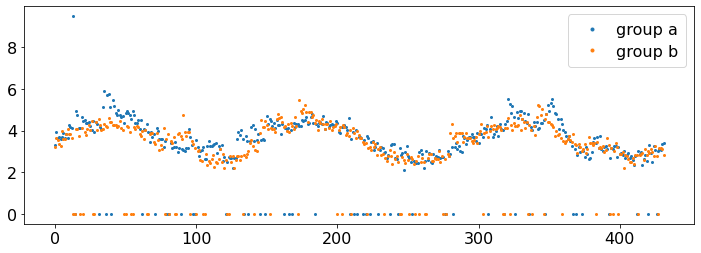

In [ ]:
fig = plt.figure(figsize=[12, 4])
plt.plot(a, 'o', markersize=2, label='group a')
plt.plot(b, 'o', markersize=2, label='group b')
plt.legend()
plt.show()

Видно, что есть много значений равных нулю, вероятно это выбросы. Давайте их отфильтуем и оценим значимость эффекта ещё раз. Это должно снизить дисперсию и увеличить чувствительность теста.

In [ ]:
filtered_a = a[a > 0]
filtered_b = b[b > 0]

print(f'a.mean = {filtered_a.mean()}')
print(f'b.mean = {filtered_b.mean()}')
print(f'delta = {filtered_b.mean() - filtered_a.mean()}')

ttest_ind(filtered_a, filtered_b)

a.mean = 3.7341255841572325
b.mean = 3.6113737411767994
delta = -0.12275184298043307


Ttest_indResult(statistic=2.2520666785369388, pvalue=0.024601986683637552)

Получили стат значимые отличия. Посмотрим как изменилась дисперсия.

In [ ]:
print(f'до\n  a: {np.std(a):0.3f}  b: {np.std(b):0.3f}')
print()
print(f'после\n  a: {np.std(filtered_a):0.3f}  b: {np.std(filtered_b):0.3f}')

до
  a: 1.382  b: 1.358

после
  a: 0.808  b: 0.690


Дисперсия уменьшилась в полтора-два раза. Получили статистически значимые отличия. Но они сильно меньше ожидаемого, практическая значимость небольшая, много на таком изменении не сэкономишь.

In [ ]:
np.mean(filtered_a) - np.mean(filtered_b)

0.12275184298043307

Отличие порядка одной десятой градуса, вместо ожидаемого одного градуса.

#### Есть другие способы понижения дисперсии для повышения чувствительности теста, о них поговорим на последующих занятиях.

In [ ]:
mu = filtered_a.mean()
std = filtered_a.std()
sample_size = len(filtered_a)
alpha = 0.05
beta = 0.2

mde = get_minimal_determinable_effect(std, sample_size, alpha, beta)

print(f'MDE = {mde}')

MDE = 0.16299122120532739
